In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path=r"C:\Users\المجد\Desktop\karam\Unsupervised ML\E-commerce_data.xlsx"
excel_data= pd.read_excel(r"C:\Users\المجد\Desktop\karam\Unsupervised ML\E-commerce_data.xlsx")

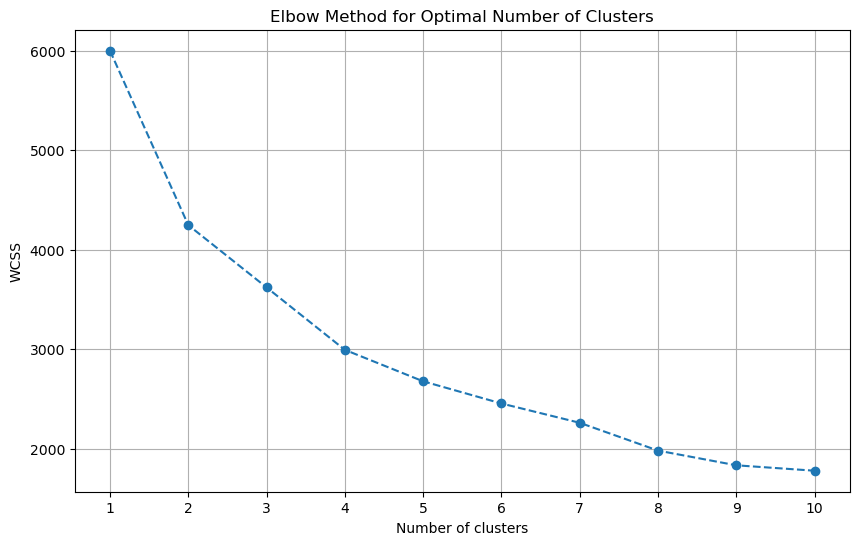

   customer_id  join_date  city_id  gender_id last_transaction_date  recency  \
0            1 2022-01-08        7          1            2024-05-26    115.0   
1            2 2023-05-02       20          2            2023-10-21    333.0   
2            3 2023-05-14       15          1            2024-07-05     75.0   
3            4 2022-11-25       11          2            2023-01-15    612.0   
4            5 2023-04-26        8          1            2024-07-02     78.0   

   transaction_count  coupons_claimed  coupons_burned  cluster  
0                7.0              7.0             3.0        0  
1                3.0              3.0             1.0        2  
2                5.0              5.0             1.0        1  
3                1.0              1.0             0.0        2  
4                4.0              4.0             3.0        1  


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
customers_df=pd.read_excel(path,sheet_name='customers')
transactions_df=pd.read_excel(path,sheet_name='transactions')
transactions_df['transaction_date']=pd.to_datetime(transactions_df['transaction_date'])
transactions_df['burn_date']=pd.to_datetime(transactions_df['burn_date'])
today=datetime.now()
last_transaction_dates=transactions_df.groupby('customer_id')['transaction_date'].max().reset_index()
last_transaction_dates.columns = ['customer_id', 'last_transaction_date']
last_transaction_dates['recency'] = (today - last_transaction_dates['last_transaction_date']).dt.days
transaction_counts = transactions_df.groupby('customer_id').size().reset_index(name='transaction_count')

coupon_usage = transactions_df.groupby('customer_id').agg(
    coupons_claimed=('transaction_id', 'count'),
    coupons_burned=('burn_date', 'count')
).reset_index()
#---------------------------------
customer_profiles=customers_df.merge(last_transaction_dates, on='customer_id', how='left')
customer_profiles=customer_profiles.merge(transaction_counts, on='customer_id', how='left')
customer_profiles=customer_profiles.merge(coupon_usage, on='customer_id', how='left')
#---------------------------------
customer_profiles.fillna({ #handling missing values(if it exists)
    'recency':customer_profiles['recency'].max(),
    'transaction_count': 0,
    'coupons_claimed':0,
    'coupons_burned': 0
},inplace=True)

features=customer_profiles[['recency','transaction_count','coupons_claimed','coupons_burned','city_id','gender_id']]
scaler=StandardScaler()
scaled_features=scaler.fit_transform(features)

wcss=[]
for n_clusters in range(1,11):  
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  #sum of squared distances to nearest cluster center
plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1,11))
plt.grid(True)
plt.show()
kmeans=KMeans(n_clusters=3,random_state=0)  
customer_profiles['cluster'] = kmeans.fit_predict(scaled_features)
print(customer_profiles.head())


In [9]:
from sklearn.metrics import silhouette_score
inertia=kmeans.inertia_
print(f"Inertia:{inertia}")
silhouette_avg = silhouette_score(scaled_features,kmeans.labels_)
print(f"Silhouette Score:{silhouette_avg}")

Inertia: 3620.555867645337
Silhouette Score: 0.2375697943281567


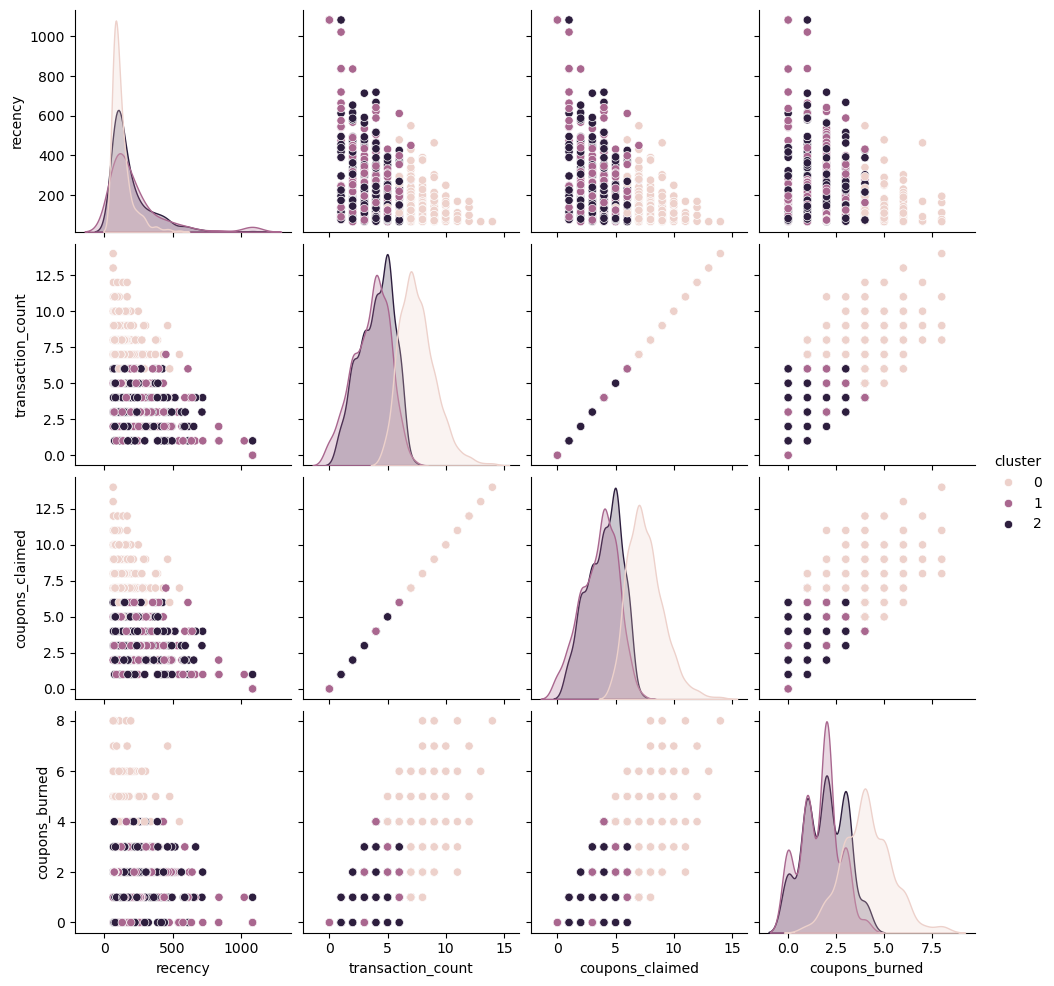

In [8]:
sns.pairplot(customer_profiles,hue='cluster',vars=['recency','transaction_count','coupons_claimed','coupons_burned'])
plt.show()

In [4]:
centroids=pd.DataFrame(kmeans.cluster_centers_,columns=features.columns)
print(centroids)

    recency  transaction_count  coupons_claimed  coupons_burned   city_id  \
0 -0.340800           1.110319         1.110319        1.008944  0.017350   
1  0.287990          -0.619080        -0.619080       -0.560705 -0.034323   
2  0.037543          -0.425952        -0.425952       -0.388823  0.016792   

   gender_id  
0  -0.129356  
1  -0.946009  
2   1.018165  


# Segment Analysis:

## 1. Cluster 0(light pink):
### Recency: 
This cluster consists of customers with higher recency values(they haven’t visited the store in a while).
### Transaction Count:
These customers have a low number of transactions.
### Coupons Claimed:
Despite the low transaction count, this group has claimed some coupons, though not as actively as other clusters.
### Coupons Burned: 
The number of burned coupons is low.
### Behavioral Insight: 
Customers in Cluster 0 are less engaged. They have not visited recently, and their transaction count is low, so they might be at risk of stopping their shopping habits at the store.

## 2. Cluster 1(purple):
### Recency: 
These customers have low to moderate recency(they visit the store somewhat frequently).
### Transaction Count: 
They have higher transaction counts compared to Cluster 0, but not as high as Cluster 2.
### Coupons Claimed: 
This group claims a good number of coupons.
### Coupons Burned: 
The number of coupons burned is medium, but lower than Cluster 2.
### Behavioral Insight: 
Customers in Cluster 1 are moderately engaged. They shop fairly regularly and are somewhat active in using coupons.

## 3. Cluster 2(dark purple):
### Recency: 
This group has the lowest recency values(they visit the store frequently).
### Transaction Count: 
These customers make the highest number of transactions.
### Coupons Claimed: 
This group claims the most coupons.
### Coupons Burned: 
They also have the highest number of burned coupons,so they receive more than they can use or they don't use all the coupons cause they don't need them.
### Behavioral Insight: 
Cluster 2 customers are the most loyal and active shoppers. They visit the store frequently, make many purchases, and are highly engaged with the store’s coupon offerings. However, the higher number of burned coupons indicates they may be overwhelmed with offers, or the coupons they receive may not always be relevant.

# Recommendations:

## 1. Cluster 0:
To re-engage this segment,We should send them attractive and high-value coupons to bring them back to the store (discounts on frequently purchased items,free items for returning to the store) may be a good solution.Offering them personalized, time-limited offers to encourage them to return is a good option too.
## 2. Cluster 1: 
We should keep these customers loyal with regular coupons but we should focus on increasing their basket size by offering bundled discounts (buy two items and get one free) or coupons for products they haven’t purchased recently to encourage variety in their purchases.
## 3. Cluster 2: 
To maximize the value from this group, we should offer more personalized and targeted coupons by focusing on optimizing the types of offers they receive to avoid coupon burnout.We can send them coupons based on their past purchase behavior also, we should offer loyalty rewards or exclusive benefits for their continued engagement and loyalty but without overloading them with offers.

In [7]:
from sklearn.decomposition import PCA
import plotly.express as px
pca=PCA(n_components=3)
principal_components=pca.fit_transform(scaled_features)
customer_profiles[['pc1','pc2','pc3']]=principal_components
fig = px.scatter_3d(customer_profiles,x='pc1',y='pc2',z='pc3',color='cluster',
                    title='3D Scatter Plot of Customer Clusters',
                    labels={'pc1': 'PC1', 'pc2': 'PC2', 'pc3': 'PC3'},
                    color_continuous_scale=px.colors.qualitative.Plotly)

fig.update_layout(scene=dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'))

fig.show()